# **ENGR 418 - Project (Stage 2)**
### *Group 33 Members:*
#### Bonn Fernandez (42101212)
#### Maxwell Rex (68722255)
---

### Imports

In [844]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage import filters, feature, color
from PIL import Image, ImageFilter
from scipy.ndimage.interpolation import rotate

### Feature Extraction (original)

In [932]:
def feature_extraction(path):
    pictures = glob.glob(path + '/*.png')             # Used the glob library to determine the content/files in a given path/folder.
    x = []                                            # Instance an empty list.
    for point in range(0,len(pictures),1):            # loops the algortithm based on the number of files in the path/folder. 
        image = imread(pictures[point],as_gray=True)  # Collects RGB data from an image in a form of 3D array. Since it's grayscaled, its truncated into a 2D data array.
        small_image = resize(image, (100, 100))
        edge_image = feature.canny(small_image, 5, 0.001, 0.07)
        img_height = edge_image.shape[0]
        img_width = edge_image.shape[1]
        area = 0
        min_width = 100
        prev_width = width = max_diff_width = 0
        sig_edges = []
        for row in range(img_height):
            first_edge = 0
            last_edge = 0
            for col in range(img_width):
                if(edge_image[row][col] == True):
                    first_edge = col
                    break
            for col in range(img_width):
                if(edge_image[row][col] == True):
                    last_edge = col
            prev_width = width
            
            # find area
            width = last_edge - first_edge
            area += width
            
            # find maximum change in width
            diff_width = abs(width-prev_width)
            if(diff_width > max_diff_width):
                max_diff_width = diff_width
            
            # find minimum width
            if(width < min_width and width != 0):
                min_width = width
                
        # straight edge detection
        for degree in range(0,46,5):
            rotated = rotate(small_image, angle=degree, reshape=False, order=1)
            edges = feature.canny(small_image, 5, 0.001, 0.07)
            column_sums = np.array(edges.sum(axis=0))
            sig_edges.append(column_sums)
        total_sig_edges = sum(sig_edges)
        x.append([area, total_sig_edges])
        
    x = np.array(x)
    #x = x.reshape(-1,1)
    return x

### getEdges Function (side quest)

In [835]:
def getEdges(image_path):
    image = imread(image_path, as_gray=True)
    image = resize(image, (100,100))        
    image = feature.canny(image, 2, 0.05, 0.5)
    img_height = image.shape[0]
    img_width = image.shape[1]
    for row in range(img_height):
        for col in range(img_width):
                if(image[row][col] == True):
                    return image
    image = imread(image_path, as_gray=True)
    image = resize(image, (100,100))        
    image = feature.canny(image, 5, 0.001, 0.07)
    return image
    

### Feature Extraction 2 (side quest)

In [836]:
def feature_extraction2(path):
    pictures = glob.glob(path + '/*.png')             # Used the glob library to determine the content/files in a given path/folder.
    x = []                                            # Instance an empty list.
    for point in range(0,len(pictures),1):            # loops the algortithm based on the number of files in the path/folder. 
        image = getEdges(pictures[point])
        img_height = image.shape[0]
        img_width = image.shape[1]
        area = 0
        min_width = 100
        prev_width = width = max_diff_width = 0
        for row in range(img_height):
            first_edge = 0
            last_edge = 0
            for col in range(img_width):
                if(image[row][col] == True):
                    first_edge = col
                    break
            for col in range(img_width):
                if(image[row][col] == True):
                    last_edge = col
            prev_width = width
            width = last_edge - first_edge
            diff_width = abs(width-prev_width)
            if(diff_width > max_diff_width):
                max_diff_width = diff_width
            area += width
            if(width < min_width and width != 0):
                min_width = width
        x.append([area, min_width, max_diff_width])
        
    x = np.array(x)
    #x = x.reshape(-1,1)
    return x

### Feature Extraction 3 (side quest)

In [885]:
def feature_extraction3(path):
    pictures = glob.glob(path + '/*.png')             # Used the glob library to determine the content/files in a given path/folder.
    x = []                                            # Instance an empty list.
    for point in range(0,len(pictures),1):            # loops the algortithm based on the number of files in the path/folder. 
        image = Image.open(pictures[point])           # Collects RGB data from an image in a form of 3D array. Since it's grayscaled, its truncated into a 2D data array.
        image = image.convert("L")
        image = image.resize((100, 100))
        image = image.filter(ImageFilter.FIND_EDGES)
        image = np.array(image)
        img_height = image.shape[0]
        img_width = image.shape[1]
        area = 0
        min_width = 100
        prev_width = width = max_diff_width = 0
        for row in range(img_height):
            first_edge = 0
            last_edge = 0
            for col in range(5,img_width-5):
                if(image[row][col] > 20):
                    first_edge = col
                    break
            for col in range(5,img_width-5):
                if(image[row][col] > 20):
                    last_edge = col
            prev_width = width
            width = last_edge - first_edge
            diff_width = abs(width-prev_width)
            if(diff_width > max_diff_width):
                max_diff_width = diff_width
            area += width
            if(width < min_width and width != 0):
                min_width = width
        x.append(area)
        
    x = np.array(x)
    x = x.reshape(-1,1)
    return x

### Label Extraction (original)

In [886]:
## Determines the # of classes and # of points per class 
def label_extraction(path):
    cir = len(glob.glob(path + '/cir_*.png')) # Determines how many circle images there are in the path.
    rec = len(glob.glob(path + '/rec_*.png')) # Determines how many rectangle images there are in the path.
    squ = len(glob.glob(path + '/squ_*.png')) # Determines how many square images there are in the path.

    i = 1
    y = []
    for shape in [cir,rec,squ]: # Creates a list whose size is determined by the # of points and their class; assuming the files in the path are organized accordingly: circle,rectangular,square 
        for j in range(0,shape,1):
            y.append(i) # Appends a class # for each corresponding shape 
        i = i+1
    y = np.array(y)# Converts the list into a numpy array.
    return y, cir, rec, squ

### Model Training

In [933]:
train_path = '/Users/Max/training'
[yp,cir,rec,squ] = label_extraction(train_path)
xp = feature_extraction(train_path)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(xp,yp)

KNeighborsClassifier(n_neighbors=1)

### Classifier/Accuracy Function (original)

In [934]:
def classifier(test_path,model):       
    x = feature_extraction(test_path) # Calls the feature_collector() function to collect features from testing dataset.
    [y,cir,squ,rec] = label_extraction(test_path) # Calls the label_vector() function to generate a label vector from the testing dataset.
    preds = model.predict(x) # Uses our trained model to classify the testing dataset.
    print(pd.crosstab(preds,y)) # Shows the Confusion Matrix to determine its quality.
    print("------------------------------------------------------")
    success = 0
    for i in [0,1,2]:
        points = [cir,rec,squ]
        shape = ['circle','rectangle','square']  
        success =  success + pd.crosstab(preds,y)[i+1][i+1]
        print(f"For the {shape[i]} lego, the accuracy of the classifier is {round((pd.crosstab(preds,y)[i+1][i+1]/points[i])*100,2)}%") # Calculates accuracy of the classifier model for each shape.
    print(f"The overall accuracy of the classifier is {round((success/pd.crosstab(preds,y).sum().sum())*100,2)}%") # Calculates the overall accuracy of the classifier model.
    return 

### Accuracy Test (Training Data)

In [935]:
training = '/Users/Max/training'
classifier(training,knn)

col_0   1   2   3
row_0            
1      27   0   0
2       0  27   0
3       0   0  27
------------------------------------------------------
For the circle lego, the accuracy of the classifier is 100.0%
For the rectangle lego, the accuracy of the classifier is 100.0%
For the square lego, the accuracy of the classifier is 100.0%
The overall accuracy of the classifier is 100.0%


### Accuracy Test (Testing Data)

In [936]:
testing = '/Users/Max/testing'
classifier(testing,knn)

col_0   1   2   3
row_0            
1      17  15  12
2       6   7  11
3       4   5   4
------------------------------------------------------
For the circle lego, the accuracy of the classifier is 62.96%
For the rectangle lego, the accuracy of the classifier is 25.93%
For the square lego, the accuracy of the classifier is 14.81%
The overall accuracy of the classifier is 34.57%


# Experimentation / Testing Section Below 

### Viewing an individual image's edges 

766


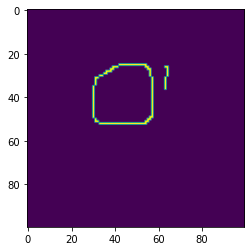

In [939]:
image = imread("/Users/Max/training/squ_14.png", as_gray=True)
#image = filters.gaussian(image, truncate=2)
image = resize(image, (100,100))
image = feature.canny(image, 2, 0.05, 0.1)  # play with the parameters, yellow lego need low thresholds (0.001, 0.1)
img_height = image.shape[0]
img_width = image.shape[1]
area = 0
for row in range(img_height):
    first_edge = 0
    last_edge = 0
    for col in range(img_width):
        if image[row][col] == True:
            first_edge = col
            break
    for col in range(img_width):
        if image[row][col] == True:
            last_edge = col
    if(last_edge != 0 and first_edge != 0):
        width = last_edge - first_edge
        area += width
    
            
plt.imshow(image)
print(area)

### Viewing all the images' edges and respective area calculations

<ipython-input-940-05d428908340>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


[['886' '3' '8' '/Users/Max/training/cir_9.png']
 ['904' '4' '6' '/Users/Max/training/cir_8.png']
 ['1990' '6' '8' '/Users/Max/training/rec_9.png']
 ['1784' '8' '9' '/Users/Max/training/rec_8.png']
 ['828' '5' '6' '/Users/Max/training/cir_11.png']
 ['2680' '3' '9' '/Users/Max/training/rec_23.png']
 ['1098' '7' '12' '/Users/Max/training/squ_22.png']
 ['1210' '6' '9' '/Users/Max/training/squ_1.png']
 ['960' '2' '7' '/Users/Max/training/squ_23.png']
 ['2198' '5' '7' '/Users/Max/training/rec_22.png']
 ['744' '3' '6' '/Users/Max/training/cir_12.png']
 ['912' '6' '6' '/Users/Max/training/squ_21.png']
 ['1180' '9' '11' '/Users/Max/training/squ_3.png']
 ['1870' '5' '11' '/Users/Max/training/squ_2.png']
 ['2934' '2' '6' '/Users/Max/training/rec_21.png']
 ['854' '4' '5' '/Users/Max/training/cir_13.png']
 ['950' '2' '7' '/Users/Max/training/cir_17.png']
 ['2042' '5' '7' '/Users/Max/training/rec_19.png']
 ['2316' '5' '8' '/Users/Max/training/rec_25.png']
 ['1028' '9' '26' '/Users/Max/training/squ_

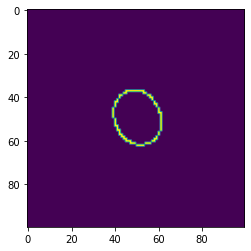

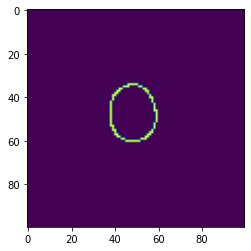

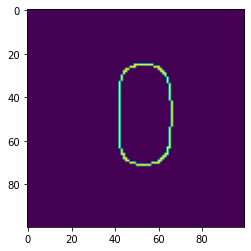

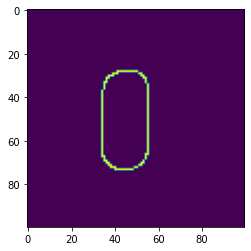

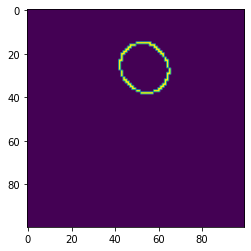

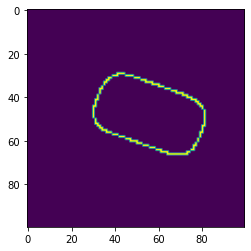

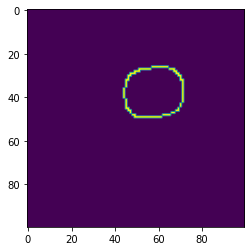

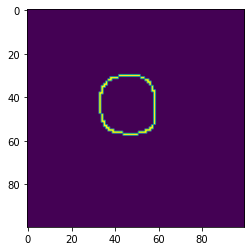

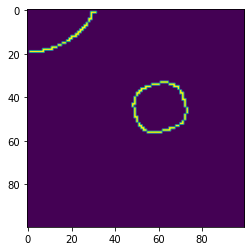

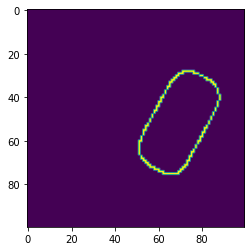

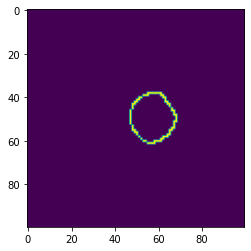

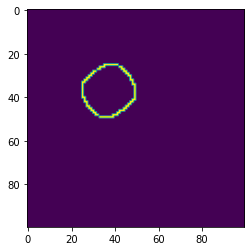

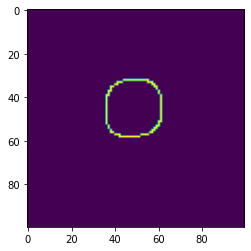

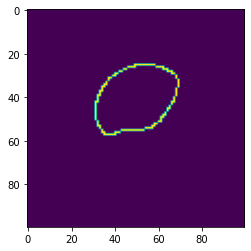

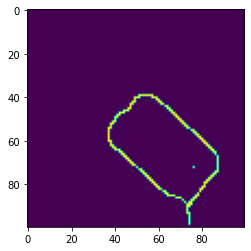

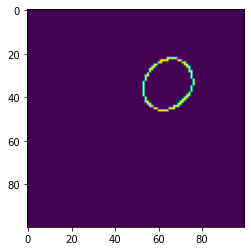

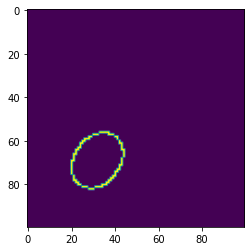

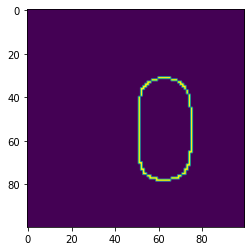

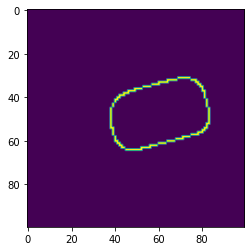

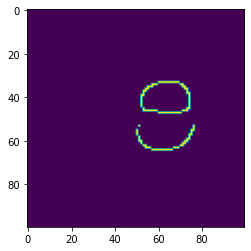

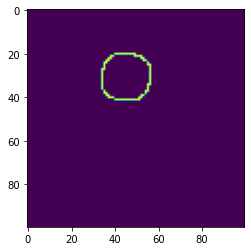

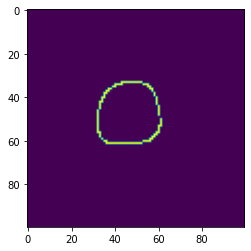

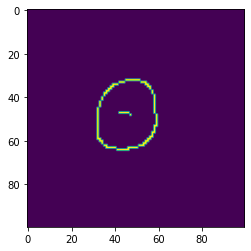

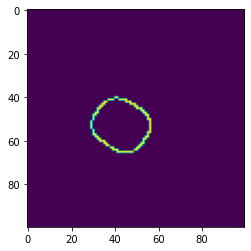

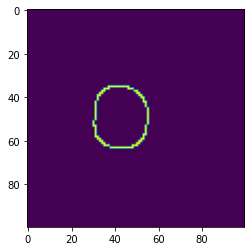

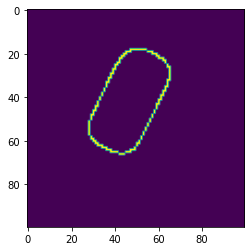

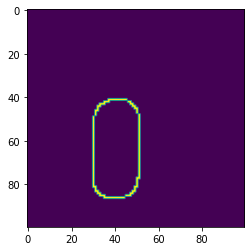

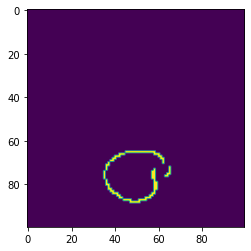

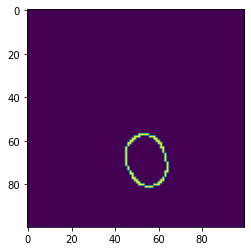

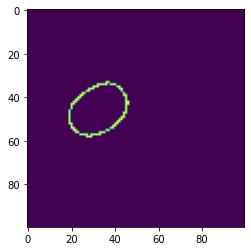

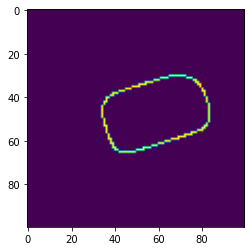

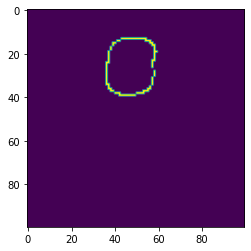

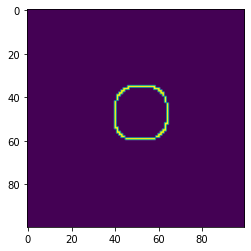

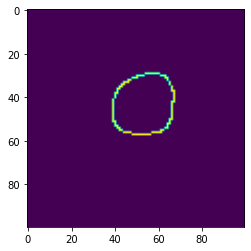

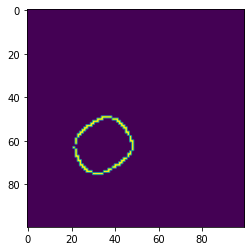

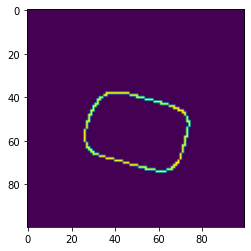

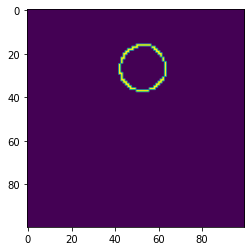

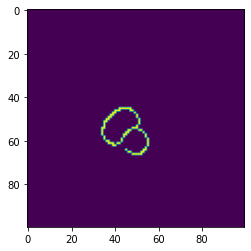

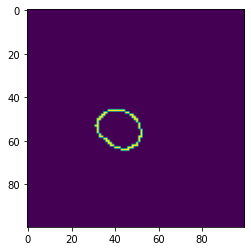

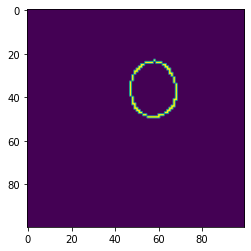

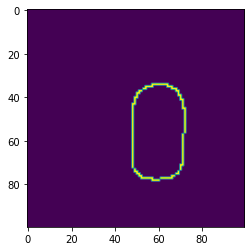

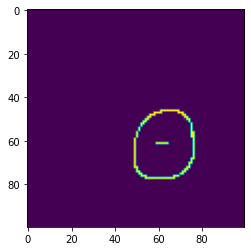

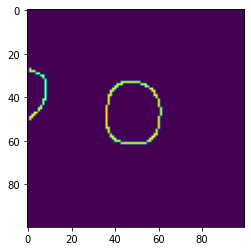

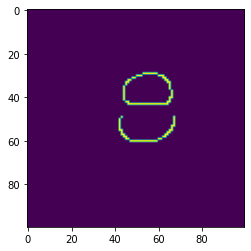

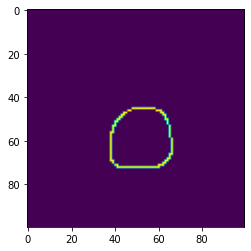

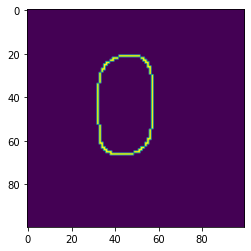

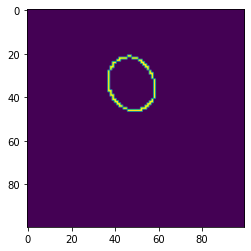

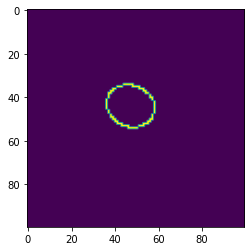

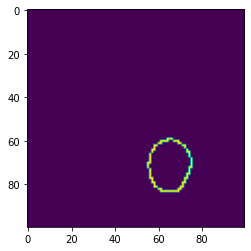

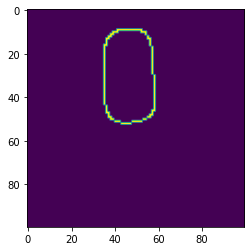

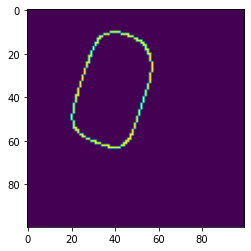

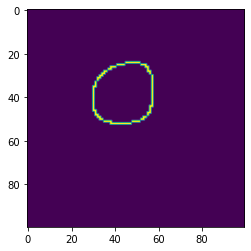

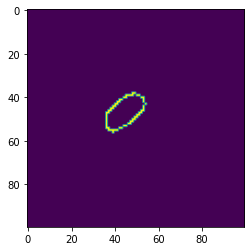

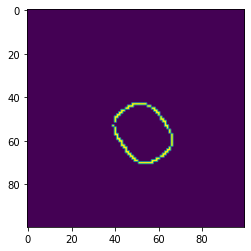

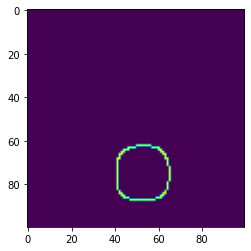

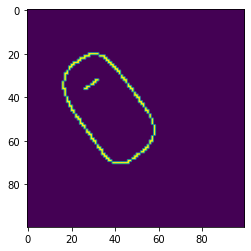

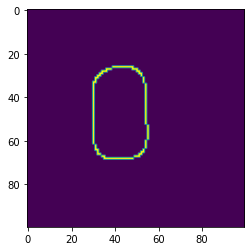

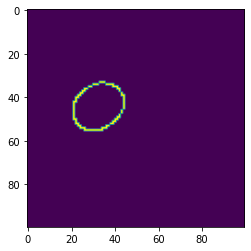

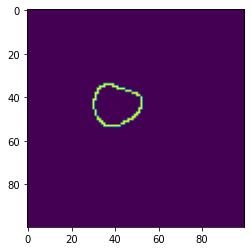

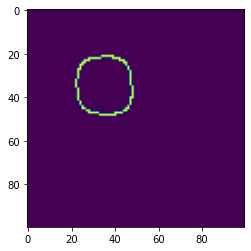

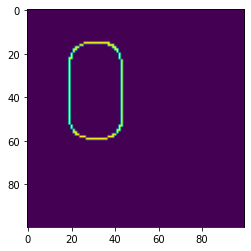

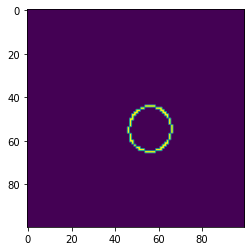

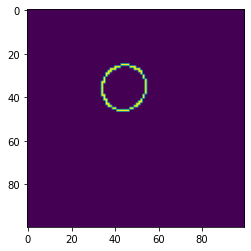

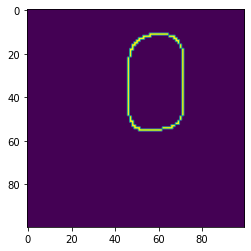

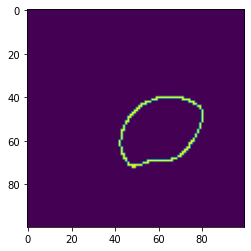

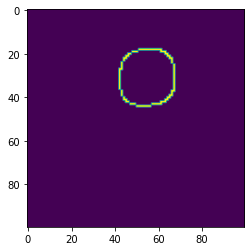

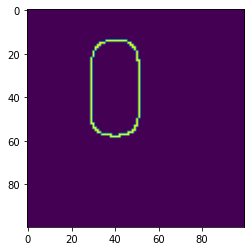

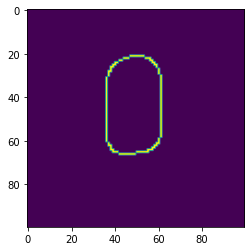

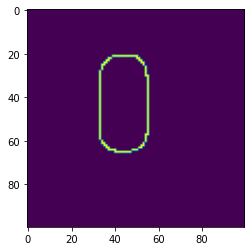

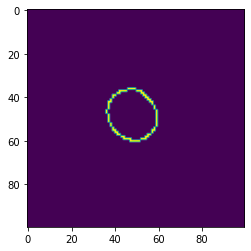

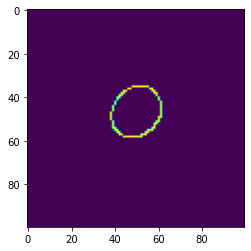

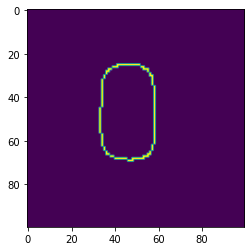

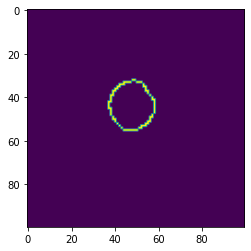

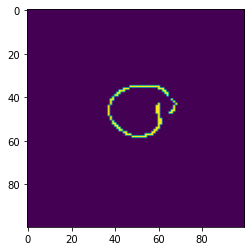

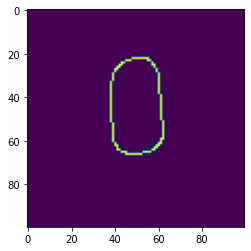

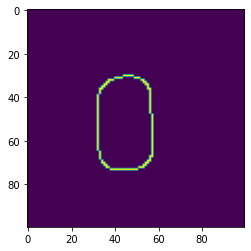

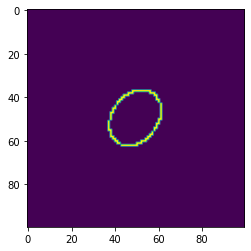

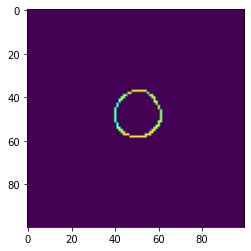

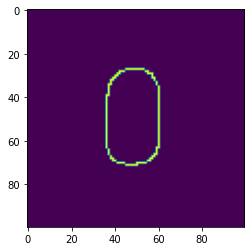

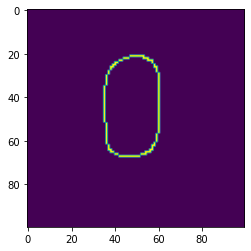

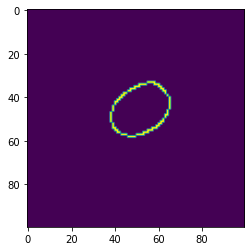

In [940]:
pictures = glob.glob('/Users/Max/training' + '/*.png')                 # Used the glob library to determine the content/files in a given path/folder.
x = []                                            # Instance an empty list.
x2 = []
for point in range(0,len(pictures),1):            # loops the algortithm based on the number of files in the path/folder. 
    image = imread(pictures[point],as_gray=True)  # Collects RGB data from an image in a form of 3D array. Since it's grayscaled, its truncated into a 2D data array.
    image = resize(image, (100, 100))
    image = feature.canny(image, 5, 0.001, 0.07)    # 2, 0.05, 0.5
    plt.figure()
    plt.imshow(image)
    img_height = image.shape[0]
    img_width = image.shape[1]
    area = 0
    min_width = 100
    prev_width = width = max_diff_width = 0
    for row in range(img_height):
        first_edge = 0
        last_edge = 0
        for col in range(img_width):
            if(image[row][col] == True):
                first_edge = col
                break
        for col in range(img_width):
            if(image[row][col] == True):
                last_edge = col
        prev_width = width
        width = last_edge - first_edge
        area += width
        diff_width = abs(width-prev_width)
        if(diff_width > max_diff_width):
            max_diff_width = diff_width
        
        area += width
        if(width < min_width and width != 0 and width != 1):
                min_width = width
    x.append([area, min_width, max_diff_width, pictures[point]])

            
        
x = np.array(x)
#for i in range(x.shape[0]):
#    if(x[i,0] == '0'):
#        x2.append(x[i,3])
#x2 = np.array(x2)
print(x)

### Leftover images' edges and area calculations

<ipython-input-730-8e0dd9b8ffde>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


[['2318' '12' '15' '/Users/Max/training/rec_9.png']
 ['1312' '6' '22' '/Users/Max/training/cir_12.png']
 ['1224' '2' '23' '/Users/Max/training/squ_2.png']
 ['3422' '4' '7' '/Users/Max/training/rec_21.png']
 ['2376' '8' '18' '/Users/Max/training/rec_19.png']
 ['1498' '6' '32' '/Users/Max/training/squ_18.png']
 ['940' '10' '11' '/Users/Max/training/squ_24.png']
 ['1534' '12' '13' '/Users/Max/training/squ_6.png']
 ['1268' '4' '14' '/Users/Max/training/cir_16.png']
 ['1226' '6' '15' '/Users/Max/training/cir_14.png']
 ['1046' '18' '19' '/Users/Max/training/squ_27.png']
 ['1506' '12' '21' '/Users/Max/training/squ_4.png']
 ['416' '4' '17' '/Users/Max/training/cir_29.png']
 ['5710' '15' '59' '/Users/Max/training/rec_16.png']
 ['1536' '4' '32' '/Users/Max/training/squ_8.png']
 ['1520' '4' '21' '/Users/Max/training/squ_16.png']
 ['896' '5' '9' '/Users/Max/training/cir_27.png']
 ['2440' '4' '17' '/Users/Max/training/rec_15.png']
 ['1532' '12' '21' '/Users/Max/training/squ_14.png']
 ['886' '2' '20

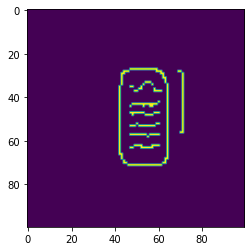

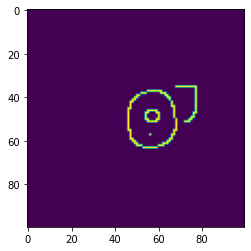

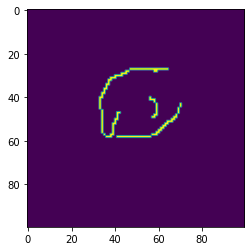

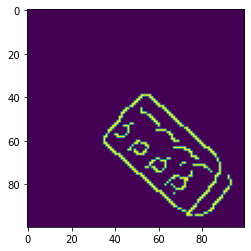

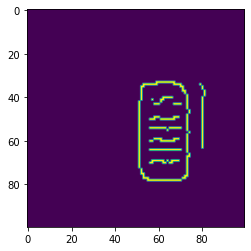

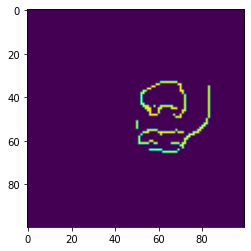

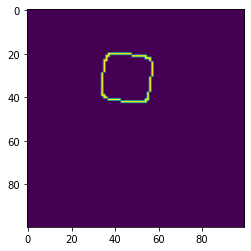

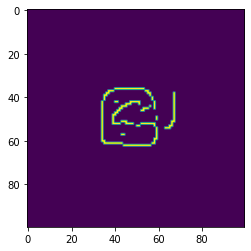

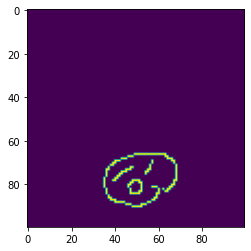

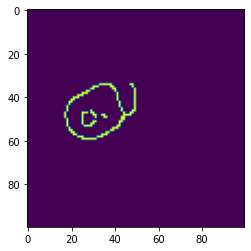

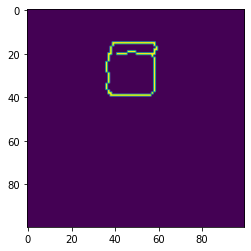

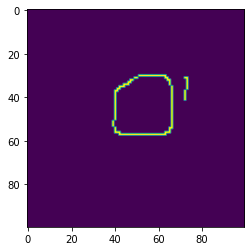

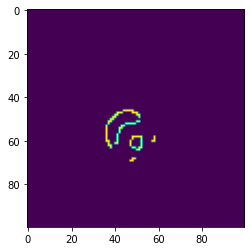

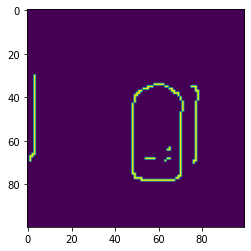

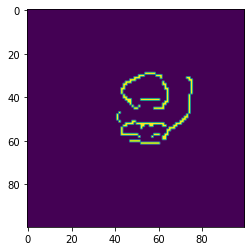

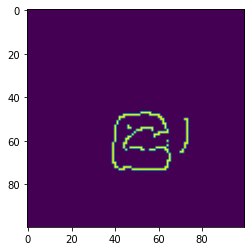

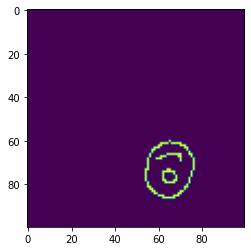

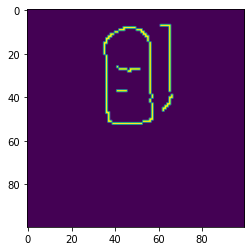

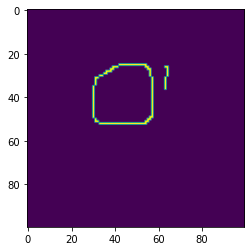

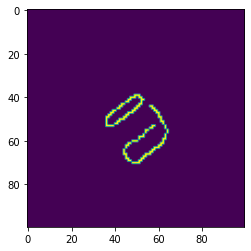

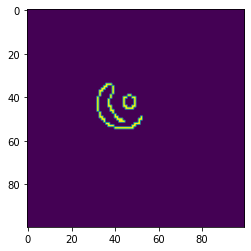

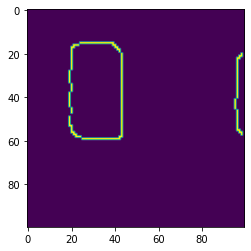

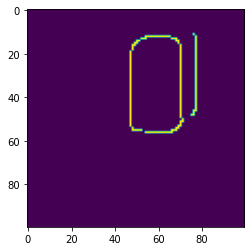

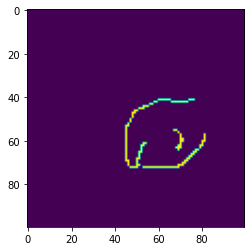

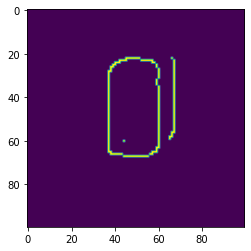

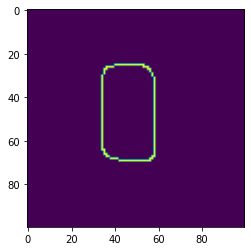

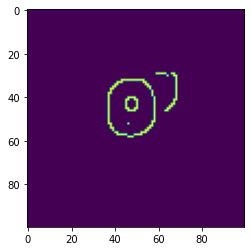

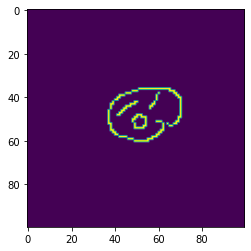

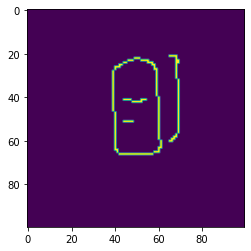

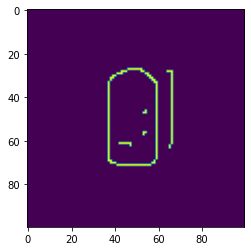

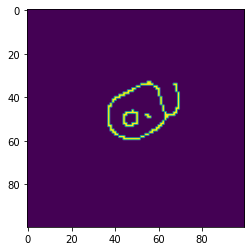

In [730]:
x = []
for point in range(0,len(x2),1):            # loops the algortithm based on the number of files in the path/folder. 
    image = imread(x2[point],as_gray=True)  # Collects RGB data from an image in a form of 3D array. Since it's grayscaled, its truncated into a 2D data array.
    image = resize(image, (100, 100))
    image = feature.canny(image, 2, 0.08, 0.1)
    plt.figure()
    plt.imshow(image)
    img_height = image.shape[0]
    img_width = image.shape[1]
    area = 0
    min_width = 100
    prev_width = width = max_diff_width = 0
    for row in range(img_height):
        first_edge = 0
        last_edge = 0
        for col in range(img_width):
            if(image[row][col] == True):
                first_edge = col
                break
        for col in range(img_width):
            if(image[row][col] == True):
                last_edge = col
        prev_width = width
        width = last_edge - first_edge
        area += width
        diff_width = abs(width-prev_width)
        if(diff_width > max_diff_width):
            max_diff_width = diff_width
        
        area += width
        if(width < min_width and width != 0 and width != 1):
                min_width = width
    x.append([area, min_width, max_diff_width, x2[point]])

            
        
x = np.array(x)
print(x)

 ### Pillow Edge Detection Trial

<ipython-input-925-45bdb53a37b8>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


[['692' '5' '89' '/Users/Max/training/cir_9.png']
 ['652' '4' '89' '/Users/Max/training/cir_8.png']
 ['1067' '3' '89' '/Users/Max/training/rec_9.png']
 ['1130' '20' '89' '/Users/Max/training/rec_8.png']
 ['689' '8' '89' '/Users/Max/training/cir_11.png']
 ['1782' '2' '89' '/Users/Max/training/rec_23.png']
 ['890' '8' '89' '/Users/Max/training/squ_22.png']
 ['908' '21' '89' '/Users/Max/training/squ_1.png']
 ['821' '3' '89' '/Users/Max/training/squ_23.png']
 ['1577' '2' '89' '/Users/Max/training/rec_22.png']
 ['539' '4' '89' '/Users/Max/training/cir_12.png']
 ['815' '3' '89' '/Users/Max/training/squ_21.png']
 ['904' '21' '89' '/Users/Max/training/squ_3.png']
 ['339' '3' '89' '/Users/Max/training/squ_2.png']
 ['1741' '4' '89' '/Users/Max/training/rec_21.png']
 ['730' '6' '89' '/Users/Max/training/cir_13.png']
 ['630' '4' '89' '/Users/Max/training/cir_17.png']
 ['1144' '19' '89' '/Users/Max/training/rec_19.png']
 ['1614' '3' '89' '/Users/Max/training/rec_25.png']
 ['453' '2' '89' '/Users/Ma

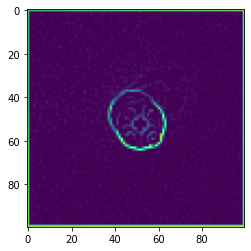

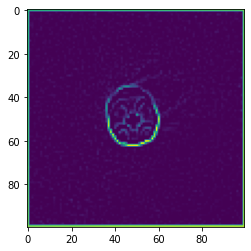

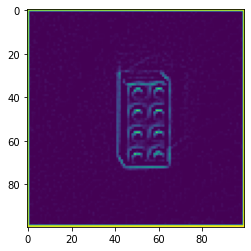

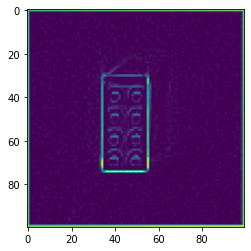

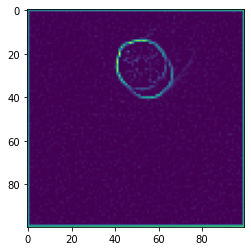

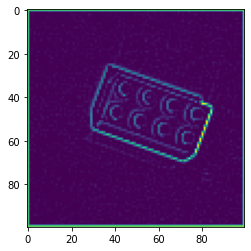

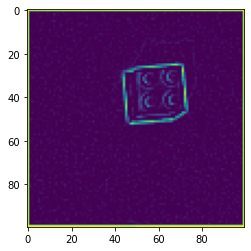

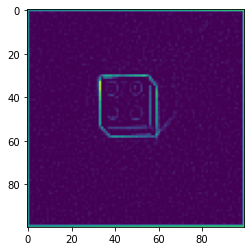

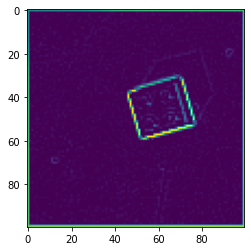

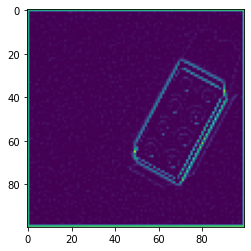

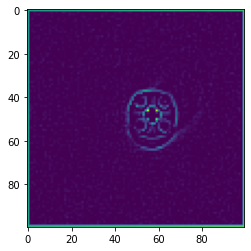

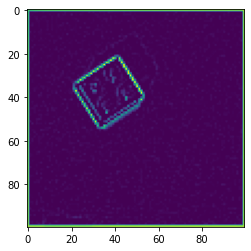

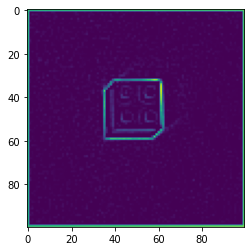

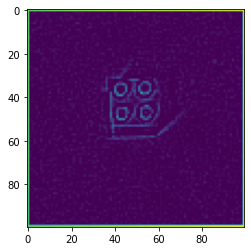

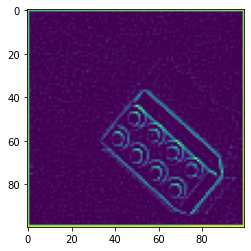

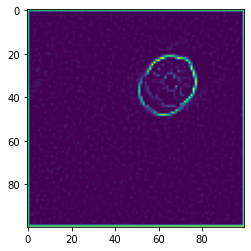

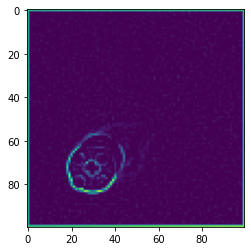

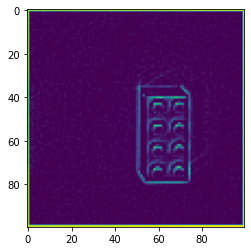

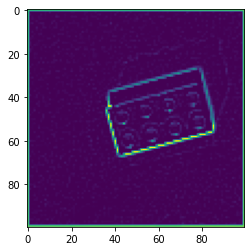

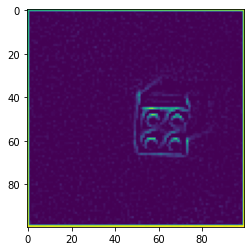

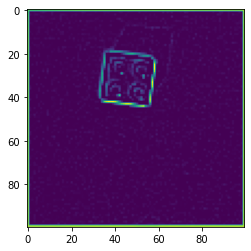

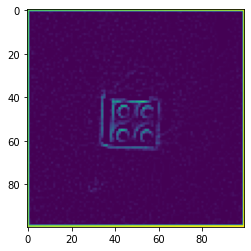

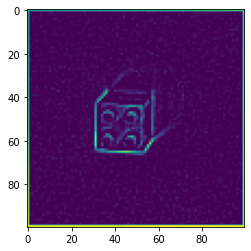

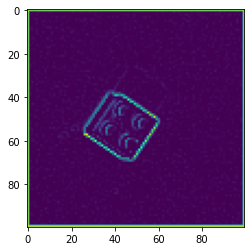

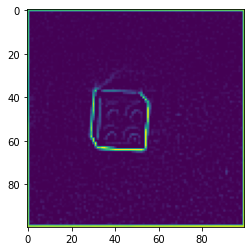

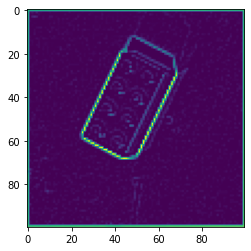

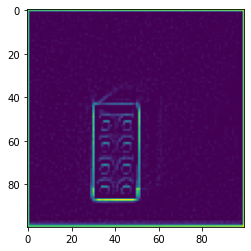

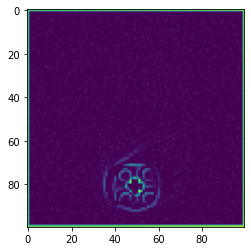

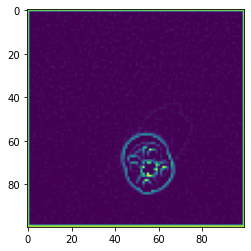

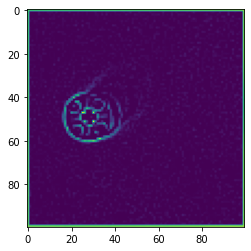

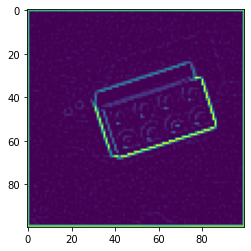

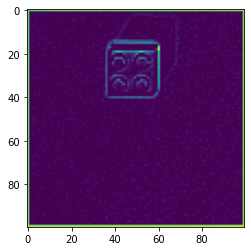

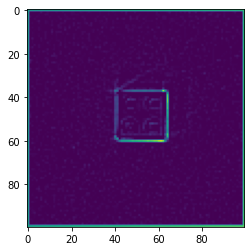

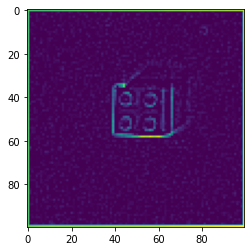

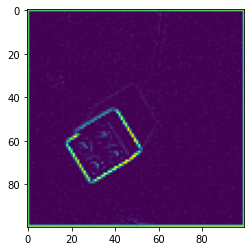

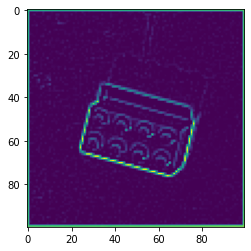

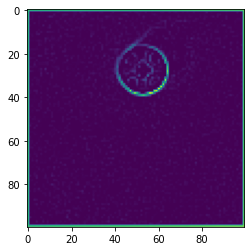

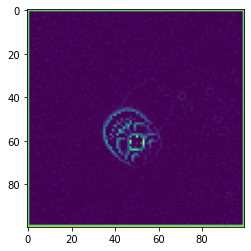

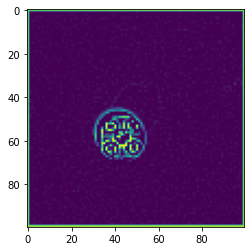

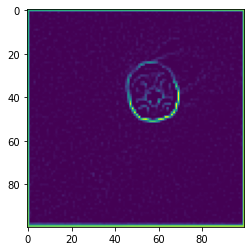

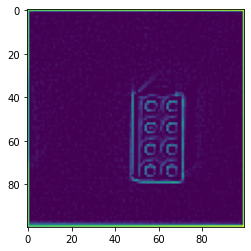

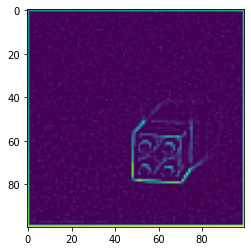

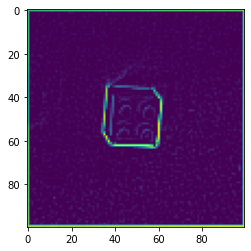

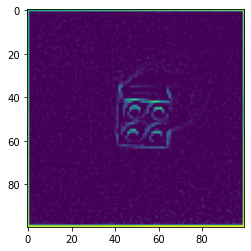

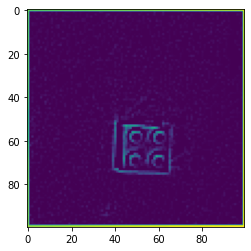

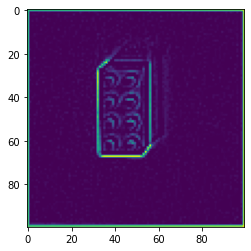

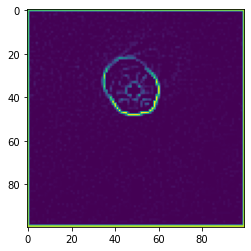

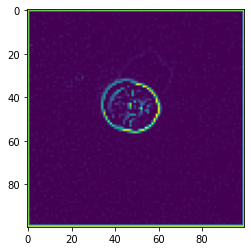

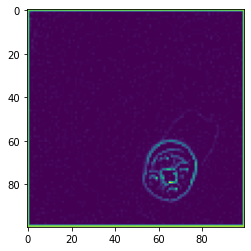

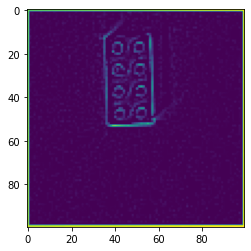

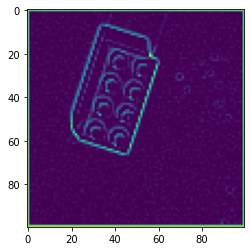

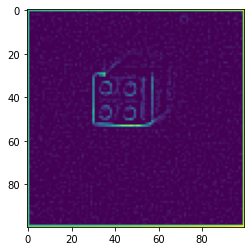

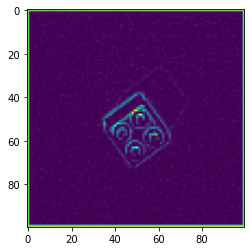

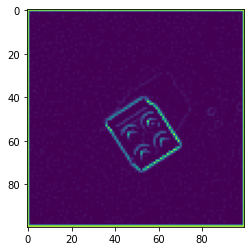

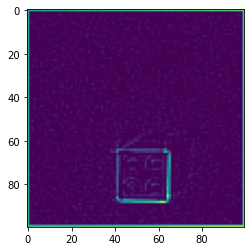

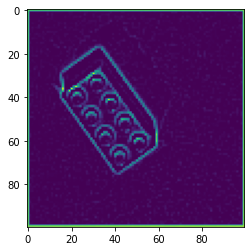

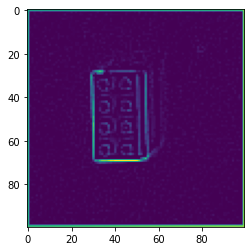

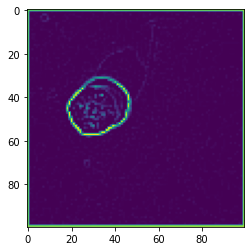

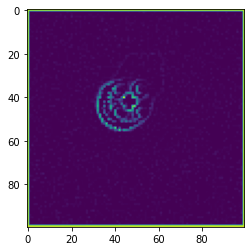

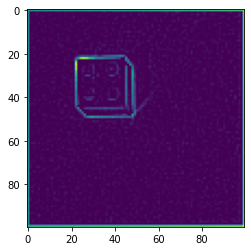

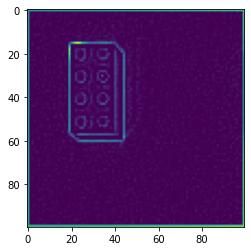

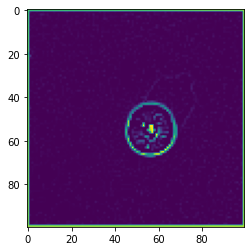

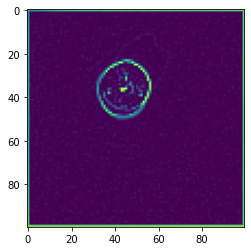

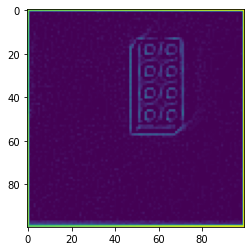

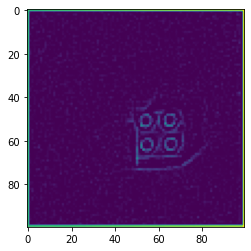

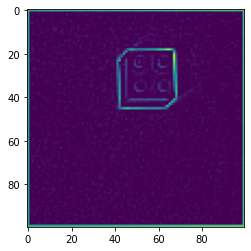

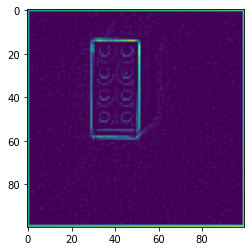

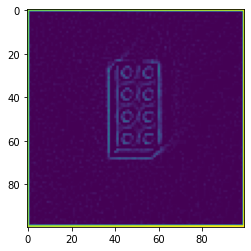

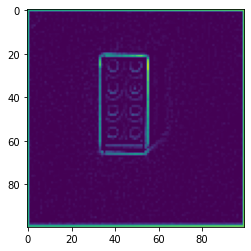

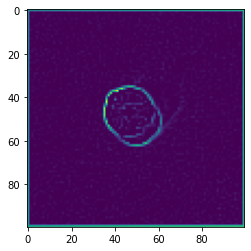

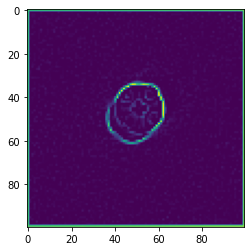

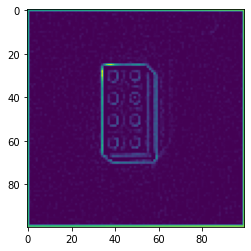

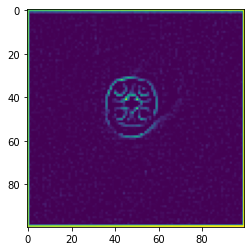

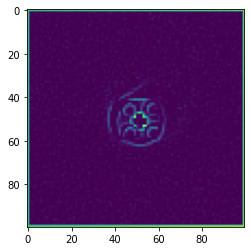

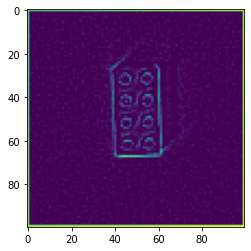

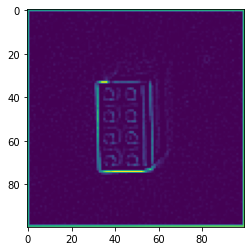

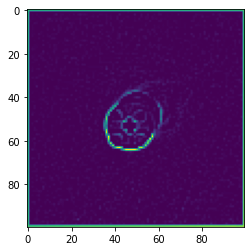

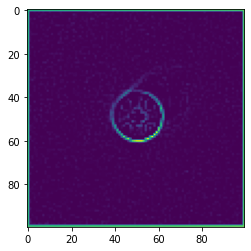

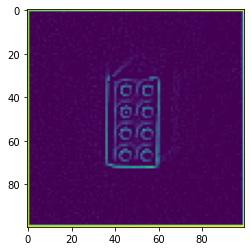

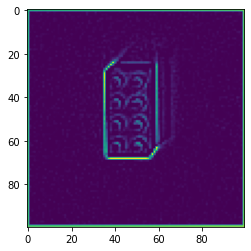

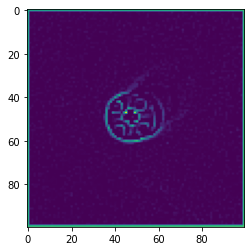

In [925]:
pictures = glob.glob('/Users/Max/training' + '/*.png')                 # Used the glob library to determine the content/files in a given path/folder.
x = []                                            # Instance an empty list.
for point in range(0,len(pictures),1):            # loops the algortithm based on the number of files in the path/folder. 
    image = Image.open(pictures[point])           # Collects RGB data from an image in a form of 3D array. Since it's grayscaled, its truncated into a 2D data array.
    image = image.convert("L")
    image = image.resize((100,100))
    image = image.filter(ImageFilter.FIND_EDGES)
    plt.figure()
    plt.imshow(image)
    image = np.array(image)
    img_height = image.shape[0]
    img_width = image.shape[1]
    area = 0
    min_width = 100
    prev_width = width = max_diff_width = 0
    for row in range(img_height):
        first_edge = 0
        last_edge = 0
        for col in range(5,img_width-5):
            if(image[row][col] > 45):
                first_edge = col
                break
        for col in range(5,img_width-5):
            if(image[row][col] > 45):
                last_edge = col
        prev_width = width
        
        # find area
        width = last_edge - first_edge
        area += width
        
        # find maximum change in width
        diff_width = abs(width-prev_width)
        if(diff_width > max_diff_width):
            max_diff_width = diff_width
            
        # find minimum width of lego
        if(width < min_width and width != 0 and width != 1):
                min_width = width
    x.append([area, min_width, max_diff_width, pictures[point]])

            
        
x = np.array(x)
#for i in range(x.shape[0]):
#    if(x[i,0] == '0'):
#        x2.append(x[i,3])
#x2 = np.array(x2)
print(x)

0
693


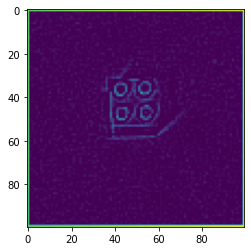

In [951]:
image = Image.open("/Users/Max/training/squ_2.png")           # Collects RGB data from an image in a form of 3D array. Since it's grayscaled, its truncated into a 2D data array.
image = image.convert("L")
image = image.resize((100,100))
image = image.filter(ImageFilter.FIND_EDGES)
image = np.array(image)
img_height = image.shape[0]
img_width = image.shape[1]
area = 0
for row in range(img_height):
    if(row < 5 or row > 95):
        continue
    first_edge = 0
    last_edge = 0
    for col in range(5,img_width-5):
        if(image[row][col] > 15):
            first_edge = col
            break
    for col in range(5,img_width-5):
        if(image[row][col] > 15):
            last_edge = col
    if(last_edge != 0 and first_edge != 0):
        width = last_edge - first_edge
        area += width
    
            
plt.imshow(image)
print(image[50][20])
print(area)